In [ ]:
# IMPORT
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
###
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [ ]:
# DATA
df1 = pd.read_csv('data_day.csv')
df2 = pd.read_csv('data_2018-08-05_2021-04-30.csv')
df3 = pd.read_csv('data_2018-05-05_2018-08-04.csv')
df4 = pd.read_csv('data_2015-08-09_2018-05-04.csv')
df5 = pd.read_csv('data_2013-02-12_2015-08-08.csv')
df6 = pd.read_csv('data_2010-05-19_to_2013-02-11.csv')
df7 = pd.read_csv('data_2007-08-23_to_2010-05-18.csv')
df8 = pd.read_csv('data_2004-11-26_to_2007-08-22.csv')
df = pd.concat([df6, df5, df4, df3, df2, df1])
df.index = range(0,4996)
df.tail()

date_time = pd.concat([pd.to_datetime(df['datetime'][0:4000]),pd.to_datetime(df['datetime'][4000:])])

In [ ]:
###
df = pd.read_csv(csv_path)
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [ ]:
###
df.columns
timestamp_s = date_time.map(pd.Timestamp.timestamp)
df = df[['p (mbar)', 'T (degC)', 'rh (%)']]

In [ ]:
df.columns

In [ ]:
###
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [ ]:
# POP DATA
# try:
#     df.pop('datetime')
# except:
#     print("time popped")
# try:
#     df.pop('name')
# except:
#     print("name popped")
count = 0
for name in df.columns:
    print(f"{name}: {df[name][0]} {type(df[name][0])}")
    if ((not isinstance(df[name][0],(int,float))) or pd.isnull(df[name][0])):
        try:
            df.pop(name)
        except:
            print(f"{name} is popped")
print(count)
df = df[['temp','humidity','precip','windspeed','solarradiation']]
df.columns

In [ ]:
# EVOLUTION OF SOME FEATURES
# plot_cols = ['Temp (degC)', 'Humidity (%)', 'Precipitation (mm)', 'Windspeed (m/s)', 'Solarradiation (kWh/m2)']
plot_cols = ['temp', 'humidity', 'precip', 'windspeed', 'solarradiation']
plot_features = df[plot_cols]

# Change index to date_time
plot_features.index = date_time
plot_features.plot(subplots=True)

plot_features = df[plot_cols][-365:-1]
plot_features.index = date_time[-365:-1]
plot_features.plot(subplots=True)

In [ ]:
# STATISTIC OF DATASET
df.describe().transpose()

In [ ]:
# TIMESTAMP

# Map values of Series according to an input mapping or function.
# Used for substituting each value in a Series with another value, that may be derived from a function, 
# a dict or a Series.
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s[1] - timestamp_s[0]


The time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important

In [ ]:
# PERIOD TIME

day = 24*60*60
year = (365.2425)*day
# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# plt.plot(np.array(df['Year sin'])[:366])
plt.plot(np.array(df['Year cos'])[:])
plt.xlabel('Time [day]')
plt.title('Time of year signal')
df.columns

In [ ]:
fft = tf.signal.rfft(df['temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_day = len(df['temp'])
days_per_year = 365.2524
years_per_dataset = n_samples_day/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
# LET features be key, value is the index of feature
input_column_indices = {name: i for i, name in enumerate(df.columns)}
print(input_column_indices)

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
# The mean and standard deviation should only be computed using the training data 
# so that the models have no access to the values in the validation and test sets.
train_mean = train_df.mean()
train_std = train_df.std()

def normalize(data):
    data_norm = (data - train_mean)/train_std
    return data_norm


train_df = normalize(train_df)
val_df = normalize(val_df)
test_df = normalize(test_df)


In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='humidity', max_subplots=4):
    inputs, labels = self.example
    plt.figure(figsize=(20, 20))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
        try:
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
        except:
            print("not 1")
        if model is not None:
            predictions = model(inputs)
            try:
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            except:
                print("not 2")
        else:
            print("BUGGGGGG")

        if n == 0:
            plt.legend()

    plt.xlabel('Time [day]')
    if model is not None:
        predictions = model(inputs)
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.scatter(labels[:, :, label_col_index],
                   predictions[:, :, label_col_index])


WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Window
window = WindowGenerator(
    input_width=60, label_width=60, shift=1,
    label_columns=['humidity'])
#  input_columns=['humidity','temp','precip','windspeed','solarradiation']

In [ ]:
# Linear Model
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', window.example[0].shape)
print('Output shape:', linear(window.example[0]).shape)


In [ ]:
val_performance = {}
performance = {}
data_train = 'temp'

In [ ]:
MAX_EPOCHS = 200
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,)
                        # callbacks=[early_stopping])
    return history


In [ ]:
history = compile_and_fit(linear, window)

val_performance['Linear'] = linear.evaluate(window.val)
performance['Linear'] = linear.evaluate(window.test, verbose=0)

In [ ]:
window.plot(linear)

In [ ]:
OUT_STEPS = 10
data_train = ['humidity']
multi_window = WindowGenerator(input_width = 20,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS, label_columns=data_train)

multi_window.plot(plot_col=data_train[0])
print(data_train[0])
multi_window

In [ ]:
multi_val_performance = {}
multi_performance = {}

In [ ]:
def statistic(models):
    count = 1
    for example_inputs, example_labels in multi_window.test.take(4):
        print(f"Example: {count}")
        count += 1
        for model in models:
            prediction = model(example_inputs)
            print("MAE")
            for i in range(10):
                print("{:.2f}".format(mean_absolute_error(prediction[:,i,0],example_labels[:,i,0])), end=" ")
            print()
            print("CORRELATION")
            for i in range(10):
                print("{:.2f}".format(np.corrcoef(prediction[:,i,0], example_labels[:,i,0])[1,0]), end = " ")
            print()

In [ ]:
df = df[['temp','humidity','precip','windspeed','solarradiation']]

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model, plot_col=data_train[0])

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model, plot_col=data_train[0])



In [ ]:
CONV_WIDTH = 10
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)


In [ ]:
multi_window.plot(multi_conv_model, plot_col=data_train[0])

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(62, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model, plot_col = data_train[0])

In [ ]:
plt.plot(history.history['loss'])
statistic([multi_lstm_model])

(1, 20, 7)
(1, 20, 7)
(1, 20, 7)
(1, 20, 7)
(1, 20, 7)
(1, 20, 7)
(1, 20, 7)
(1, 20, 7)
(1, 20, 7)
(1, 20, 7)


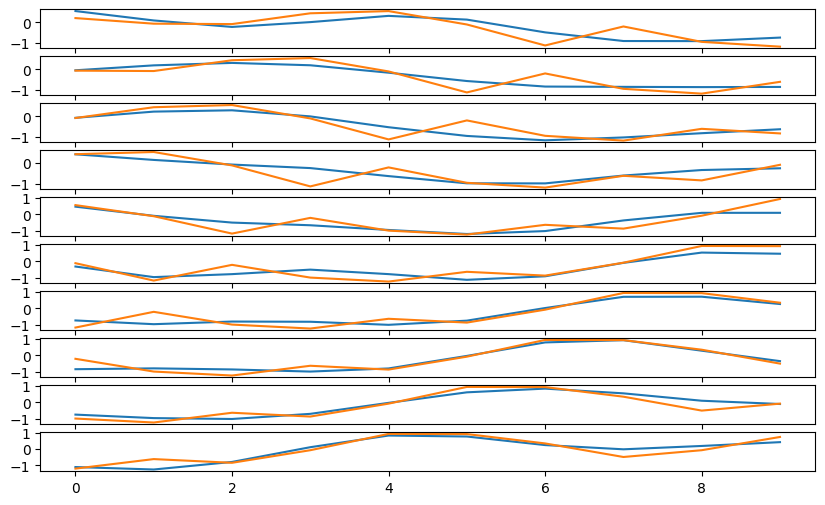

In [60]:
ds = tf.keras.utils.timeseries_dataset_from_array(
      data=train_df,
      targets=None,
      sequence_length=multi_window.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=1,)

ds = ds.map(multi_window.split_window)
it = iter(ds)
for i in range(10):
    input, output = next(it)
    print(input.shape)
    prediction = multi_lstm_model(input)
    plt.subplot(10,1,i+1)
    plt.plot(prediction[0,:,0])
    plt.plot(output[0,:,0])


In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)


In [ ]:
multi_window.plot(feedback_model, plot_col=data_train[0])
statistic([feedback_model])

In [ ]:
plt.plot(history.history['loss'])
statistic([multi_conv_model])

In [ ]:
list_models = [multi_linear_model,multi_dense_model,multi_conv_model,multi_lstm_model]
statistic(models = list_models)

In [ ]:
for key,value in multi_performance.items():
    print(f"{key} - Loss: {value[0]}, MAE: {value[1]} ")